Step 1.1: Load Data

In [1]:
from deepdow.benchmarks import OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset
from deepdow.data import RigidDataLoader
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, CumulativeReturn
from deepdow.nn import BachelierNet
from deepdow.utils import raw_to_Xy
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from pandas_ta import Imports
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import torch
import yfinance as yf

import warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

# CREDIT TO DeepDow library
# This project utilizes DeepDow framework which provides and end-to-end Machine Learning based Portfloio Allocation. 
# Our primary focus is on feature engineering and tuning hyperparameters to show improvement of portfolio allocation using ML model.


2024-02-26 12:21:20.703628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 12:21:20.703673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 12:21:20.704503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 12:21:20.709930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 12:21:21.407860: W tensorflow/compiler/tf2

In [2]:
# DEFINE EXPERIMENT PARAMETER (incl. Hyperparameters) HERE

tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'TSLA', 'SPY']
start   = '2023-01-01'
end     = '2024-01-01'
daily_rates = 0.01 / 365

lookback, gap, horizon = 10, 1, 5

num_epochs = 120
batch_size = 32

In [3]:
original = yf.download(tickers, start=start, end=end)
print('original', original.shape)


[*********************100%%**********************]  6 of 6 completed

original (250, 36)


Step 1.2: Add Features

In [4]:
def features(df, stoch_lookback=15, scale=True):
    df = df.swaplevel(0, 1, 1)

    scale_min = 0.01
    scale_max = 1.00

    for ticker in df.columns.levels[0]:
        rsi = df[ticker].ta.rsi()
        rsi = pd.DataFrame(rsi.values, index=rsi.index, columns=['RSI'])
        rsi = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(rsi), index=rsi.index, columns=rsi.columns)
        df[(ticker,'RSI')] = rsi

        macd = df[ticker].ta.macd()
        macd = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(macd), index=macd.index, columns=macd.columns)
        for c in macd.columns:
            df[(ticker, c)] = macd[c]

        bbands = df[ticker].ta.bbands()
        bbands = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(bbands), index=bbands.index, columns=bbands.columns)
        for c in bbands.columns:
            df[(ticker, c)] = bbands[c]

        stoch = df[ticker].ta.stoch(append=True)
        stoch = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(stoch), index=stoch.index, columns=stoch.columns)
        for c in stoch.columns:
            df[(ticker, c)] = stoch[c]

        obv = df[ticker].ta.obv()
        obv = pd.DataFrame(obv.values, index=obv.index, columns=['OBV'])
        obv = pd.DataFrame(MinMaxScaler((scale_min, scale_max)).fit_transform(obv), index=obv.index, columns=obv.columns)
        df[(ticker,'OBV')] = obv
    return df.ffill().dropna(axis=0).swaplevel(0, 1, 1)

df = features(original).swaplevel(0, 1, 1)

n_timesteps = len(df)
n_channels = len(df.columns.levels[1])
n_assets = len(df.columns.levels[0])

print('n_timesteps\t', n_timesteps)
print('n_assets\t', n_assets)
print('n_channels (features)\t', n_channels)
print('features', df.columns.levels[1])

df.head()

n_timesteps	 217
n_assets	 6
n_channels (features)	 18
features Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0',
       'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'OBV'],
      dtype='object', name='Price')


Ticker            AAPL       GOOG        META        MSFT         SPY  \
Price        Adj Close  Adj Close   Adj Close   Adj Close   Adj Close   
Date                                                                    
2023-02-21  147.691666  92.050003  171.897614  250.613129  393.115204   
2023-02-22  148.119385  91.800003  170.938629  249.462585  392.573425   
2023-02-23  148.606766  91.070000  171.857651  252.696045  394.661682   
2023-02-24  145.931061  89.349998  170.209412  247.191223  390.445740   
2023-02-27  147.134628  90.099998  169.360306  248.123581  391.775543   

Ticker            TSLA        AAPL       GOOG        META        MSFT  ...  \
Price        Adj Close       Close      Close       Close       Close  ...   
Date                                                                   ...   
2023-02-21  197.369995  148.479996  92.050003  172.080002  252.669998  ...   
2023-02-22  200.860001  148.910004  91.800003  171.119995  251.509995  ...   
2023-02-23  202.070007  149.399994  91.070000  172.039993  254.770004  ...   
2023-02-24  196.880005  146.710007  89.349998  170.389999  249.220001  ...   
2023-02-27  207.630005  147.919998  90.099998  169.539993  250.160004  ...   

Ticker              TSLA                                              \
Price      MACDh_12_26_9 MACDs_12_26_9 BBL_5_2.0 BBM_5_2.0 BBU_5_2.0   
Date                                                                   
2023-02-21      0.224836      1.000000  0.531489  0.541014  0.520556   
2023-02-22      0.198305      0.972063  0.520547  0.531460  0.512773   
2023-02-23      0.186770      0.943187  0.535022  0.517601  0.474171   
2023-02-24      0.153898      0.911635  0.522214  0.511725  0.474855   
2023-02-27      0.190334      0.883048  0.524176  0.510950  0.471660   

Ticker                                                                
Price      BBB_5_2.0 BBP_5_2.0 STOCHk_14_3_3 STOCHd_14_3_3       OBV  
Date                                                                  
2023-02-21  0.289661  0.120296      0.733226      0.841008  0.561056  
2023-02-22  0.298271  0.344245      0.666115      0.757780  0.599972  
2023-02-23  0.156103  0.496003      0.566640      0.651012  0.629665  
2023-02-24  0.191993  0.241610      0.474792      0.562113  0.600811  
2023-02-27  0.178008  0.934098      0.524990      0.513568  0.633479  

[5 rows x 108 columns]

Step 2: Prepare X, y

In [5]:
print('- lookback \t', lookback)
print('- gap\t\t', gap)
print('- horizon \t', horizon)
X, timestamps, y, asset_names, indicators = raw_to_Xy(df, lookback=lookback,
                                                      gap=gap, freq="B", horizon=horizon)

print('X', X.shape)
print('y', y.shape)
print('asset_names', asset_names)
print('indicators', indicators)

dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

- lookback 	 10
- gap		 1
- horizon 	 5
X (208, 18, 10, 6)
y (208, 18, 5, 6)
asset_names ['AAPL', 'GOOG', 'META', 'MSFT', 'SPY', 'TSLA']
indicators ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'OBV']


Step 4: Train Model

In [6]:
train_test_ratio = 0.8
n_samples = n_timesteps - lookback - horizon - gap + 1
split_ix = int(n_samples * 0.8)
train_ix = list(range(split_ix))
test_ix = list(range(split_ix + lookback + horizon, n_samples))

train_dataloader = RigidDataLoader(dataset, indices=train_ix, batch_size=32)
test_dataloader = RigidDataLoader(dataset, indices=test_ix, batch_size=32)

In [7]:
max_weight = 0.5
hidden_size = 32
network = BachelierNet(n_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)
loss = SharpeRatio(returns_channel=0)
loss = CumulativeReturn()
benchmarks = {'1overN': OneOverN()}
metrics = {'drawdown': MaximumDrawdown(),
           'cumreturn': CumulativeReturn()
           }


run = Run(network,
          loss,
          train_dataloader,
          val_dataloaders={'test': test_dataloader},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

history = run.launch(n_epochs=20)

Epoch 15: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s, loss=-0.00408, test_loss=-0.00801]


Training interrupted
Training stopped early because there was no improvement in test_loss for 15 epochs


Reference: The evaluation and visualization code was from DeepDow example.

In [8]:
per_epoch_results = history.metrics.groupby(
    ['dataloader', 'metric', 'model', 'epoch'])['value']

print(per_epoch_results.count())  # double check number of samples each epoch
print(per_epoch_results.mean())  # mean loss per epoch

dataloader  metric  model    epoch
test        loss    network  0        26
                             1        26
                             2        26
                             3        26
                             4        26
                             5        26
                             6        26
                             7        26
                             8        26
                             9        26
                             10       26
                             11       26
                             12       26
                             13       26
                             14       26
                             15       26
Name: value, dtype: int64
dataloader  metric  model    epoch
test        loss    network  0       -0.008108
                             1       -0.008091
                             2       -0.008081
                             3       -0.008075
                             4       -0.008068
             

<Axes: xlabel='epoch'>

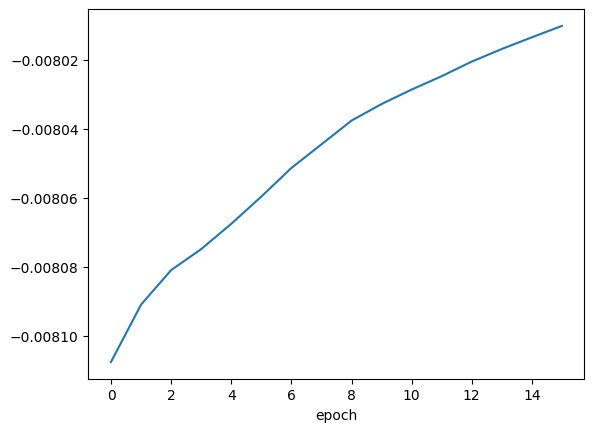

In [9]:
per_epoch_results.mean()['test']['loss']['network'].plot()

array([<Axes: title={'center': 'MaxDD'}, xlabel='timestamp'>,
       <Axes: title={'center': 'Sharpe'}, xlabel='timestamp'>],
      dtype=object)

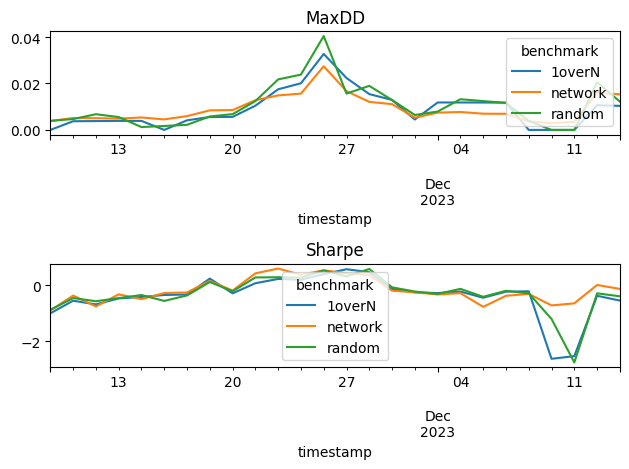

In [10]:

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network
}
metrics = {
    'MaxDD': MaximumDrawdown(),
    'Sharpe': SharpeRatio(),
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

array([<Axes: title={'center': 'MeanReturn'}, xlabel='timestamp'>,
       <Axes: title={'center': 'CumReturn'}, xlabel='timestamp'>],
      dtype=object)

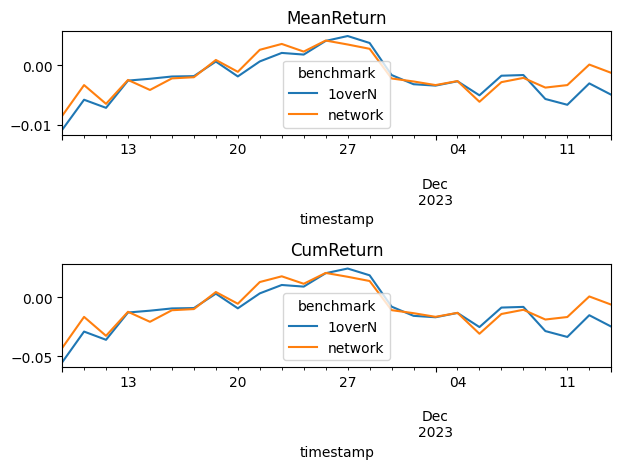

In [11]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'network': network
}
metrics = {
    'MeanReturn': MeanReturns(),
    'CumReturn': CumulativeReturn()
}

metrics_table = generate_metrics_table(benchmarks,
                                       test_dataloader,
                                       metrics)
plot_metrics(metrics_table)

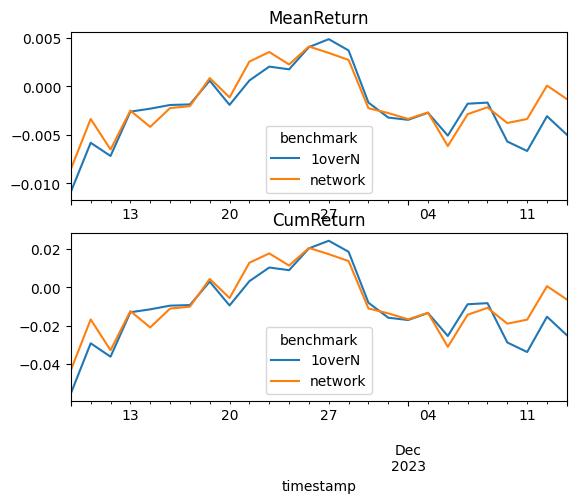

In [12]:
import matplotlib.pyplot as plt

all_metrics = metrics_table["metric"].unique()
n_metrics = len(all_metrics)

_, axs = plt.subplots(n_metrics)

for i, metric_name in enumerate(all_metrics):
    df = pd.pivot_table(
        metrics_table[metrics_table["metric"] == metric_name],
        values="value",
        columns="benchmark",
        index="timestamp",
    ).sort_index()
    df.plot(ax=axs[i])
    axs[i].set_title(metric_name)

plt.show()

<Axes: >

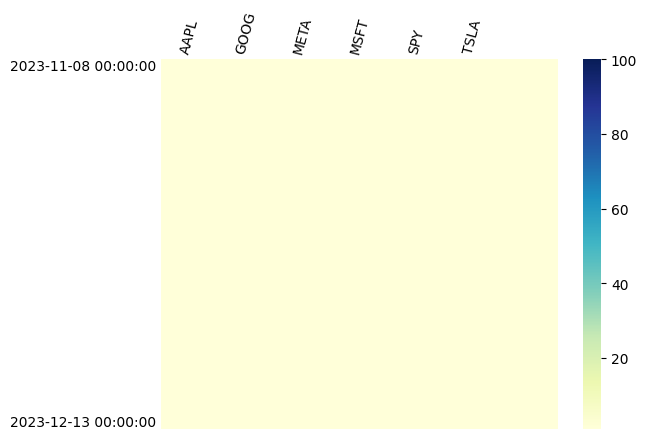

In [13]:

weight_table = generate_weights_table(network, test_dataloader)

plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25,
                    vmin=100)